In [1]:
# Import required packages
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow.keras as K
import tensorflow_hub as hub
import os
import PIL
from datetime import datetime
import collections
import timeit

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`.

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse  ship   cat
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer  bird plane


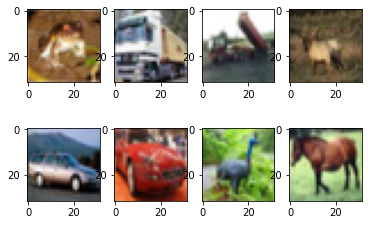

In [9]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(10)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(10)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [15]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [16]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [17]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2 Model I (Treating noisy labels as clean)

##### Train-test data split

In [3]:
#X_train, X_test, y_train, y_test = train_test_split(imgs[:10000], clean_labels, test_size=0.2, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train_40k = imgs[10000:] / 255.0
y_train_40k = noisy_labels[10000:]

X_valid_10k = imgs[:10000] / 255.0
y_valid_10k = clean_labels

#X_valid, X_test, y_valid, y_test = train_test_split(imgs[:10000], clean_labels, test_size=0.5, random_state=42)
#X_valid = np.array(X_valid) / 255.0

In [ ]:
#X_train_all = np.concatenate((X_train, X_train_noisy))
#y_train_all = np.concatenate((y_train, y_train_noisy))
#X_train_all = np.array(X_train_all) / 255.0
#X_valid = np.array(X_valid) / 255.0

#### 2.2.1 CNN without data augmentation

In [4]:
# https://www.tensorflow.org/tutorials/images/cnn
cnn = Sequential()
cnn.add(layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32, 32, 3)))
cnn.add(layers.MaxPooling2D(2, 2))
cnn.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
cnn.add(layers.MaxPooling2D(2, 2))
cnn.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))

# add dense layers on top
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

# compile the model
cnn.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [5]:
# set parameters for autosaving the model with the best validation accuracy
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as ''
filepath_cnn = '../output/saved_model/cnn'
checkpoint = K.callbacks.ModelCheckpoint(filepath=filepath_cnn, # remember to change the path
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [6]:
#train the model and autosave the model with the best validation accuracy
cnn_history = cnn.fit(X_train_40k,
                      y_train_40k, 
                      epochs = 20, 
                      validation_data=(X_valid_10k, y_valid_10k),
                      shuffle=True,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      verbose=1)

Epoch 1/20
1249/1250 [============================>.] - ETA: 0s - loss: 2.2720 - accuracy: 0.1496
Epoch 1: val_accuracy improved from -inf to 0.36670, saving model to ../output/saved_model\cnn
INFO:tensorflow:Assets written to: ../output/saved_model\cnn\assets
1250/1250 [==============================] - 56s 44ms/step - loss: 2.2721 - accuracy: 0.1495 - val_loss: 2.0456 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/20
1249/1250 [============================>.] - ETA: 0s - loss: 2.2362 - accuracy: 0.1928
Epoch 2: val_accuracy improved from 0.36670 to 0.42440, saving model to ../output/saved_model\cnn
INFO:tensorflow:Assets written to: ../output/saved_model\cnn\assets
1250/1250 [==============================] - 57s 46ms/step - loss: 2.2362 - accuracy: 0.1928 - val_loss: 1.9311 - val_accuracy: 0.4244 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 2.2150 - accuracy: 0.2114
Epoch 3: val_accuracy improved from 0.42440 to 0.47000, saving model to ../output

In [7]:
# Save the fit history
import pickle
with open('../output/evaluation_model/cnn_history', 'wb') as fp:
    pickle.dump(cnn_history, fp)
    
# Load the history fit back from the pickle file.
# import pickle
# cnn_history = pickle.load(open("../output/evaluation_model/cnn_hisotry", "rb"))

INFO:tensorflow:Assets written to: ram://4c0f0dc4-a56d-45d3-b5b9-84be90366de1/assets


In [8]:
# load the model
filepath_cnn = '../output/saved_model/cnn'
cnn = K.models.load_model(filepath=filepath_cnn)

#### 2.2.2 CNN with data augmentation

In [53]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# data augomentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(32, 
                                                              32,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


cnn_aug = Sequential([
  data_augmentation,
  layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
    ])

# compile the model
cnn_aug.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [54]:
# set parameters for autosaving the model with the best validation accuracy
filepath_cnn_aug = '../output/saved_model/cnn_aug'
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as ''
checkpoint = K.callbacks.ModelCheckpoint(filepath=filepath_cnn_aug, # remember to change the path
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [55]:
#train the model and autosave the model with the best validation accuracy
cnn_aug_history = cnn_aug.fit(X_train_40k,
                      y_train_40k, 
                      epochs = 25, 
                      validation_data=(X_valid_10k, y_valid_10k),
                      shuffle=True,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      verbose=1)

Epoch 1/25
1248/1250 [============================>.] - ETA: 0s - loss: 2.2861 - accuracy: 0.1311
Epoch 1: val_accuracy improved from -inf to 0.33950, saving model to ../output/saved_model\cnn_aug
INFO:tensorflow:Assets written to: ../output/saved_model\cnn_aug\assets
1250/1250 [==============================] - 35s 28ms/step - loss: 2.2861 - accuracy: 0.1312 - val_loss: 2.0185 - val_accuracy: 0.3395 - lr: 0.0010
Epoch 2/25
1249/1250 [============================>.] - ETA: 0s - loss: 2.2547 - accuracy: 0.1755
Epoch 2: val_accuracy improved from 0.33950 to 0.37200, saving model to ../output/saved_model\cnn_aug
INFO:tensorflow:Assets written to: ../output/saved_model\cnn_aug\assets
1250/1250 [==============================] - 42s 34ms/step - loss: 2.2548 - accuracy: 0.1754 - val_loss: 1.9612 - val_accuracy: 0.3720 - lr: 0.0010
Epoch 3/25
1249/1250 [============================>.] - ETA: 0s - loss: 2.2425 - accuracy: 0.1874
Epoch 3: val_accuracy improved from 0.37200 to 0.39540, saving mo

In [56]:
# Save the fit history
import pickle
with open('../output/evaluation_model/cnn_aug_hisotry', 'wb') as fp:
    pickle.dump(cnn_aug_history, fp)
    
# Load the history fit back from the pickle file.
# import pickle
# cnn_history = pickle.load(open("../output/evaluation_model/cnn_aug_hisotry", "rb"))

INFO:tensorflow:Assets written to: ram://9852fb5d-54ed-405b-8afc-91809fbe176e/assets


In [57]:
# load the model
filepath_cnn_aug = '../output/saved_model/cnn_aug'
cnn_aug = K.models.load_model(filepath=filepath_cnn_aug)

Comparison between CNN without data augmentation and CNN with data augmentation

1. running time of predict 10k pictures

In [58]:
start = timeit.default_timer()

y_pred = cnn.predict(X_valid_10k)

stop = timeit.default_timer()
print(f'-----The Model 1(a) takes {stop - start:.2f} seconds to run 10k predictions-----')

start2 = timeit.default_timer()

y_pred = cnn_aug.predict(X_valid_10k)

stop2 = timeit.default_timer()
print(f'-----The Model 1(b) takes {stop2 - start2:.2f} seconds to run 10k predictions-----')

-----The Model 1(a) takes 2.22 seconds to run 10k predictions-----
-----The Model 1(b) takes 1.68 seconds to run 10k predictions-----


2. Validation accuracy

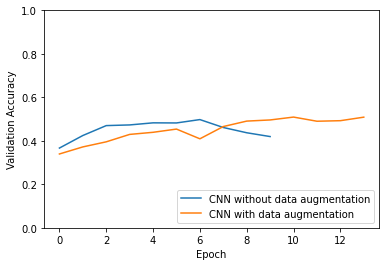

In [59]:
plt.plot(cnn_history.history['val_accuracy'], label = 'CNN without data augmentation')
plt.plot(cnn_aug_history.history['val_accuracy'], label = 'CNN with data augmentation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('../figs/model_1_val_ac_comparison')
plt.show()

3. Validation Loss

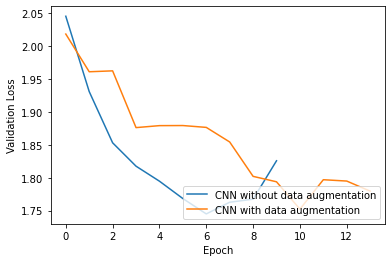

In [60]:
plt.plot(cnn_history.history['val_loss'], label='CNN without data augmentation')
plt.plot(cnn_aug_history.history['val_loss'], label='CNN with data augmentation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(loc='lower right')
plt.savefig('../figs/model_1_val_loss_comparison')
plt.show()

After comparing the performance of CNN without data augmentation and CNN with data augmentation, we choose CNN with data augmentation as our Model I

In [61]:
def model_I(image):
#      '''
#     This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
#     '''
    X = image/255.0
    # predict
    y_pred = cnn_aug.predict(X)
    y_pred_labels = [np.argmax(x) for x in y_pred]
    return y_pred_labels

### 2.3. Model II (After cleaning the labels)

#### Correct the noisy labels
We put the code in the '../doc/label_correction_model.ipynb' to keep this notebook tidy.

After the model is created to clean the labels, cleaned labels are saved in output, and they are used in the below model

#### Load the data (cleaned labels)

In [62]:
cleaned_labels = np.genfromtxt('../output/cleaned_labels.csv', delimiter=',', dtype="int8")
y_train_cleaned = cleaned_labels[10000:]

In [68]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# data augomentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(32, 
                                                              32,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


model_2 = Sequential([
  data_augmentation,
  layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10)
    ])

# compile the model
model_2.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [69]:
# set parameters for autosaving the model with the best validation accuracy
filepath_model_2 = '../output/saved_model/model_2'
# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as ''
checkpoint = K.callbacks.ModelCheckpoint(filepath=filepath_model_2, # remember to change the path
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [70]:
#train the model and autosave the model with the best validation accuracy
model_2_history = model_2.fit(X_train_40k,
                      y_train_cleaned, # use the corrected labels to train the data
                      epochs = 25, 
                      validation_data=(X_valid_10k, y_valid_10k),
                      shuffle=True,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      verbose=1)

Epoch 1/25
1248/1250 [============================>.] - ETA: 0s - loss: 1.6302 - accuracy: 0.4061
Epoch 1: val_accuracy improved from -inf to 0.50250, saving model to ../output/saved_model\model_2
INFO:tensorflow:Assets written to: ../output/saved_model\model_2\assets
1250/1250 [==============================] - 35s 27ms/step - loss: 1.6299 - accuracy: 0.4062 - val_loss: 1.3912 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/25
1250/1250 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.5193
Epoch 2: val_accuracy improved from 0.50250 to 0.54010, saving model to ../output/saved_model\model_2
INFO:tensorflow:Assets written to: ../output/saved_model\model_2\assets
1250/1250 [==============================] - 40s 32ms/step - loss: 1.3541 - accuracy: 0.5193 - val_loss: 1.3302 - val_accuracy: 0.5401 - lr: 0.0010
Epoch 3/25
1249/1250 [============================>.] - ETA: 0s - loss: 1.2529 - accuracy: 0.5544
Epoch 3: val_accuracy improved from 0.54010 to 0.57880, saving mo

In [71]:
# Save the fit history
import pickle
with open('../output/evaluation_model/model_2_hisotry', 'wb') as fp:
    pickle.dump(model_2_history, fp)
    
# Load the history fit back from the pickle file.
# import pickle
# cnn_history = pickle.load(open("../output/evaluation_model/cnn_aug_hisotry", "rb"))

INFO:tensorflow:Assets written to: ram://38bf0aca-5f9f-49ad-82b5-1e0e17bc98b1/assets


In [72]:
# load the model
filepath_model_2 = '../output/saved_model/model_2'
cnn_aug = K.models.load_model(filepath=filepath_model_2)

#### Comparison between model I and Model II

1. running time of predict 10k pictures

In [73]:
start2 = timeit.default_timer()

y_pred = cnn_aug.predict(X_valid_10k)

stop2 = timeit.default_timer()
print(f'-----The Model I(b) takes {stop2 - start2:.2f} seconds to run 10k predictions-----')

start3 = timeit.default_timer()

y_pred = cnn.predict(X_valid_10k)

stop3 = timeit.default_timer()
print(f'-----The Model II takes {stop3 - start3:.2f} seconds to run 10k predictions-----')

-----The Model I(b) takes 1.80 seconds to run 10k predictions-----
-----The Model II takes 2.18 seconds to run 10k predictions-----


2. Validation accuracy

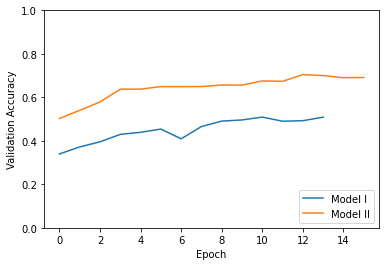

In [74]:
plt.plot(cnn_aug_history.history['val_accuracy'], label = 'Model I')
plt.plot(model_2_history.history['val_accuracy'], label = 'Model II')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('../figs/model_1&2_val_ac_comparison')
plt.show()

3. Validation Loss

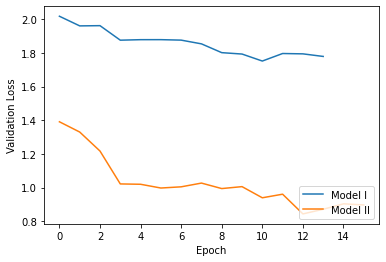

In [75]:
plt.plot(cnn_aug_history.history['val_loss'], label='Model I')
plt.plot(model_2_history.history['val_loss'], label='Model II')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(loc='lower right')
plt.savefig('../figs/model&2_1_val_loss_comparison')
plt.show()

In [76]:
def model_II(image):
#      '''
#     This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
#     '''
    X = image/255.0
    # predict
    y_pred = model_2.predict(X)
    y_pred_labels = [np.argmax(x) for x in y_pred]
    return y_pred_labels

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [77]:
# load the model 1
filepath_cnn_aug = '../output/saved_model/cnn_aug'
cnn_aug = K.models.load_model(filepath=filepath_cnn_aug)

In [78]:
# load the model 2
filepath_model_2 = '../output/saved_model/model_2'
model_2 = K.models.load_model(filepath=filepath_model_2)

In [79]:
def model_I(image):
#      '''
#     This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
#     '''
    X = image/255.0
    # predict
    y_pred = cnn_aug.predict(X)
    y_pred_labels = [np.argmax(x) for x in y_pred]
    return y_pred_labels

In [80]:
def model_II(image):
#      '''
#     This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
#     '''
    X = image/255.0
    # predict
    y_pred = model_2.predict(X)
    y_pred_labels = [np.argmax(x) for x in y_pred]
    return y_pred_labels

# if there is only one image:
# model_II()

In [81]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels.tolist()
    y_pred = model(test_imgs)
    print(classification_report(y_true, y_pred))

In [ ]:
# For final test
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
# n_test = 10000
# test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
# test_imgs = np.empty((n_test,32,32,3))
# for i in range(n_test):
#     img_fn = f'../data/test_images/test{i+1:05d}.png'
#     test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
# evaluation(baseline_model, test_labels, test_imgs)

In [94]:
# This is just for our trial, remember to delete this cell
n_test = 10000
test_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/images/{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

In [98]:
# test for Baseline Model
start = timeit.default_timer()
y_true = test_labels.tolist()
y_pred_baseline = np.array([baseline_model(x) for x in test_imgs])
print(classification_report(y_true, y_pred_baseline))
stop = timeit.default_timer()
print(f'-----Baseline Model takes {stop - start:.2f} seconds-----')

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000

-----Baseline Model takes 2.42 seconds-----


In [95]:
# test for CNN with augmentation (Model_I)
start = timeit.default_timer()

evaluation(model_I, test_labels, test_imgs)

stop = timeit.default_timer()
print(f'-----The Model I takes {stop - start:.2f} seconds-----')

              precision    recall  f1-score   support

           0       0.59      0.47      0.52      1005
           1       0.60      0.62      0.61       974
           2       0.46      0.29      0.36      1032
           3       0.40      0.30      0.34      1016
           4       0.46      0.40      0.43       999
           5       0.42      0.44      0.43       937
           6       0.52      0.68      0.59      1030
           7       0.54      0.63      0.58      1001
           8       0.61      0.58      0.60      1025
           9       0.47      0.68      0.55       981

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000

-----The Model I takes 1.89 seconds-----


In [96]:
# test for CNN with augmentation (Model_II)
start = timeit.default_timer()

evaluation(model_II, test_labels, test_imgs)

stop = timeit.default_timer()
print(f'-----The Model II takes {stop - start:.2f} seconds-----')

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1005
           1       0.74      0.88      0.81       974
           2       0.59      0.66      0.62      1032
           3       0.65      0.39      0.49      1016
           4       0.74      0.57      0.64       999
           5       0.63      0.63      0.63       937
           6       0.77      0.72      0.75      1030
           7       0.68      0.83      0.75      1001
           8       0.83      0.76      0.79      1025
           9       0.71      0.82      0.76       981

    accuracy                           0.70     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.70      0.70     10000

-----The Model II takes 1.89 seconds-----


In [99]:
y_pred_baseline = np.array([baseline_model(x) for x in test_imgs])
y_pred_I = np.array(model_I(test_imgs))
y_pred_II = np.array(model_II(test_imgs))

In [100]:
pred_labels = np.genfromtxt('../output/label_prediction.csv', delimiter=',', dtype="int8")

pred_labels[1:,1:2] = y_pred_baseline
pred_labels[1:,2] = y_pred_I
pred_labels[1:,3] = y_pred_II

import pandas as pd
df = pd.DataFrame(pred_labels)
df[0][1:] = np.array([f'test{i+1:05d}' for i in range(10000)])
df = df[:][1:]
df.to_csv('../output/label_prediction.csv', index=False , header = ["Index", "Baseline", "Model I", "Model II"])